# Make Big Plot 

Code for combining all data to do with wildfire DRF effect

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

# display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = 10000

In [2]:
###############################################################
####################### user inputs ###########################
###############################################################

# enter study start and end dates, formatted "dd/mm/yyyy"
interval_start = "01/01/2000"
interval_end = "02/01/2020"

# two variables would you like to run a spearman correlation on
var1 = "RECO_PI"
var2 = "AOD_500nm"

# variable with which to make boxplots sorted by smoke lvl
boxvar = "AOD_500nm"

###############################################################
###############################################################

In [3]:
# convert inputs to a pandas dataframe
start = pd.to_datetime(interval_start, format="%d/%m/%Y")
end = pd.to_datetime(interval_end, format="%d/%m/%Y")

interval = pd.date_range(start, end, freq="1H")
interval_df = pd.DataFrame({"datetime":interval})

In [11]:
# get the datasets
path_to_data = "C:/Users/Owner/Wildfire_Smoke_Mckendry/data/out_data/"

# csv format makes datetimes into strings. convert them back
# to pandas Timestamp objects
aeronet = pd.read_csv(path_to_data + "aeronet_aod.csv")
aeronet["datetime"] = pd.to_datetime(aeronet["datetime"])

hazmap = pd.read_csv(path_to_data + "hazmap_wask.csv")
hazmap["datetime"] = pd.to_datetime(hazmap["datetime"])

fluxes = pd.read_csv(path_to_data + "OBS_ameriflux.csv")
fluxes["datetime"] = pd.to_datetime(fluxes["datetime"])

aeronet.keys()

Index(['datetime', 'AOD_1640nm', 'AOD_1020nm', 'AOD_870nm', 'AOD_865nm',
       'AOD_779nm', 'AOD_675nm', 'AOD_667nm', 'AOD_620nm', 'AOD_560nm',
       'AOD_555nm', 'AOD_551nm', 'AOD_532nm', 'AOD_531nm', 'AOD_510nm',
       'AOD_500nm', 'AOD_490nm', 'AOD_443nm', 'AOD_440nm', 'AOD_412nm',
       'AOD_400nm', 'AOD_380nm', 'AOD_340nm', 'Precipitable_Water(cm)',
       'AOD_681nm', 'AOD_709nm', 'Ozone(Dobson)', 'NO2(Dobson)'],
      dtype='object')

In [5]:
# join all dataframes by date inside of spec interval
full_dataset = interval_df.merge(aeronet, how="left", on="datetime")
full_dataset = full_dataset.merge(hazmap, how="left", on="datetime")
full_dataset = full_dataset.merge(fluxes, how="left", on="datetime")

In [6]:
#full_dataset.to_csv("C:/Users/Owner/Wildfire_Smoke_Mckendry/data/out_data/drf_test.csv")

In [7]:
def spearman_correlate(val1, val2):
    """
    Calculates the spearman correlation between 
    two variables in the master dataset
    
    in: any pair of keys from
    
       'datetime', 'AOD_1640nm', 'AOD_1020nm', 'AOD_870nm', 'AOD_865nm',
       'AOD_779nm', 'AOD_675nm', 'AOD_667nm', 'AOD_620nm', 'AOD_560nm',
       'AOD_555nm', 'AOD_551nm', 'AOD_532nm', 'AOD_531nm', 'AOD_510nm',
       'AOD_500nm', 'AOD_490nm', 'AOD_443nm', 'AOD_440nm', 'AOD_412nm',
       'AOD_400nm', 'AOD_380nm', 'AOD_340nm', 'Precipitable_Water(cm)',
       'AOD_681nm', 'AOD_709nm', 'Ozone(Dobson)', 'NO2(Dobson)', 'smoke',
       'USTAR', 'TA', 'WD', 'WS', 'NEE_PI', 'FC', 'SC', 'H', 'SH', 'LE', 'SLE',
       'G', 'TS_1', 'TS_2', 'P', 'RH', 'PA', 'CO2_1', 'CO2_2', 'VPD_PI',
       'SWC_1', 'SWC_2', 'NETRAD', 'PPFD_IN', 'SW_IN', 'SW_DIF', 'PPFD_OUT',
       'SW_OUT', 'LW_IN', 'LW_OUT', 'H2O', 'RECO_PI', 'APAR', 'PPFD_DIF',
       'FAPAR', 'ZL']
       
    out: spearman correlation coefficient and P value from val1 and val2
    
    Spearman's correlation coefficient for ordinal data (smoke levels arent ratio data!)
    https://towardsdatascience.com/discover-the-strength-of-monotonic-relation-850d11f72046
    """
    cor, pval = spearmanr(full_dataset[val1], full_dataset[val2], nan_policy="omit")

    print(f"Variables: {val1}, {val2}\nCorrelation: {cor}  P-value: {pval}")
    # return cor, pval

Variables: RECO_PI, AOD_500nm
Correlation: 0.26764833590035375  P-value: 5.4582127861591435e-08


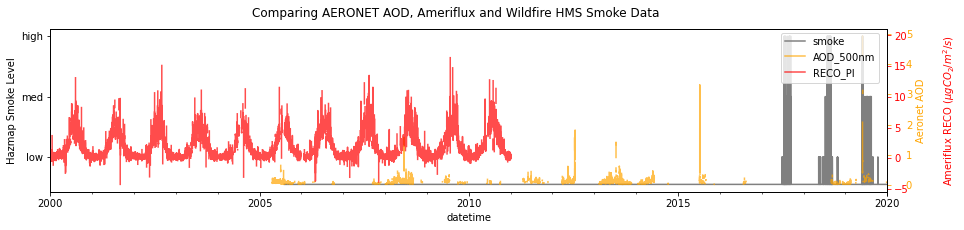

In [8]:
# plot the whole timeseries
fig, ax1 = plt.subplots(figsize=(15,3))

# hazmap
full_dataset.plot("datetime", "smoke", ax=ax1, color="grey", legend=False)
plt.yticks(ticks=[5,16,27], labels=["low", "med", "high"])
ax1.set_ylabel("Hazmap Smoke Level")

ax2 = ax1.twinx()
full_dataset.plot("datetime", "AOD_500nm", ax=ax2, color="orange", alpha=0.7, legend=False)
plt.yticks(color="orange")
ax2.set_ylabel("Aeronet AOD", color="orange")
ax2.tick_params(axis="y", color="orange", pad=15)

ax3 = ax1.twinx()
full_dataset.plot("datetime", "RECO_PI", ax=ax3, color="red", alpha=0.7, legend=False)
plt.yticks(color="red")
ax3.set_ylabel("Ameriflux RECO ($\mu g CO_2/m^2/s$)", color="red", labelpad=32)
ax3.tick_params(axis="y", color="red")

fig.suptitle("Comparing AERONET AOD, Ameriflux and Wildfire HMS Smoke Data")
plt.figlegend(loc=(0.81,0.64))

spearman_correlate(var1, var2)

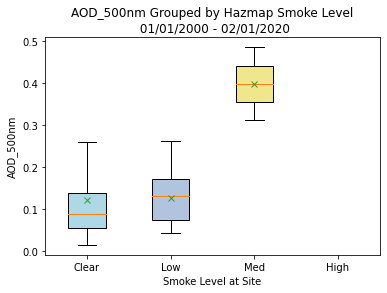

In [10]:
# make boxplots of [variable] over smoke levels 0, 1, 2, 3

# omit nan values and sort data by smoke level
boxdata = full_dataset[np.isnan(full_dataset[boxvar]) == False]
boxdata_zero = boxdata[boxdata["smoke"] == 0]
boxdata_low = boxdata[boxdata["smoke"] == 5]
boxdata_med = boxdata[boxdata["smoke"] == 16]
boxdata_high = boxdata[boxdata["smoke"] == 27]

# do the boxplot
fig, ax = plt.subplots()
bplot = ax.boxplot(
    [
        boxdata_zero[boxvar],
        boxdata_low[boxvar],
        boxdata_med[boxvar],
        boxdata_high[boxvar],
    ],
    labels=["Clear", "Low", "Med", "High"],
    patch_artist=True,
    boxprops={"facecolor": "red"},
    sym="",
    showmeans=True,
    meanprops={"marker":'x'}
)

# fill with colors
colors = ["lightblue", "lightsteelblue", "khaki", "goldenrod"]
for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)

# do some labeling
ax.set_title(f"{boxvar} Grouped by Hazmap Smoke Level\n {interval_start} - {interval_end}")
ax.set_xlabel("Smoke Level at Site")
ax.set_ylabel(boxvar);